<div align='center'>

# Inference

### Part of Scientific-ML-Notes 

[![GitHub](https://img.shields.io/badge/GitHub-Repository-black?logo=github&scale=5)](https://github.com/mhnaderi/Scientific-ML-Notes)

---

In [1]:
# Always run this cell first to import all necessary libraries and set up the notebook environment

import numpy as np
import scipy.stats as st
from scipy.stats import norm

import jax
import optax
import jax.numpy as jnp
from functools import partial
from jax.lax import scan, cond
from jax import random, jit, grad, vmap
from jax.scipy.stats import multivariate_normal

import seaborn as sns
from tqdm import trange
import matplotlib.pyplot as plt

# Enable inline plotting for Jupyter Notebook
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# Update matplotlib parameters for consistent styling
plt.rcParams.update({
    "font.family": "serif",
    "figure.facecolor": 'white',
    "axes.facecolor": 'white'
})

In probabilistic machine learning, all unknown quantities—such as future predictions, hidden states of a system, or model parameters—are treated as random variables with associated probability distributions. Inference involves computing the posterior distribution of these quantities, conditioned on the observed data.

Let $\boldsymbol{\theta}$ represent the unknown variables and $\mathcal{D}$ represent the observed data. Using Bayes' theorem, we compute the posterior distribution $p(\boldsymbol{\theta} \mid \mathcal{D})$ as:

$$
p(\boldsymbol{\theta} \mid \mathcal{D}) = \frac{p(\boldsymbol{\theta}) \, p(\mathcal{D} \mid \boldsymbol{\theta})}{p(\mathcal{D})}
$$

where $p(\boldsymbol{\theta})$ is the prior distribution and $p(\mathcal{D} \mid \boldsymbol{\theta})$ is the likelihood.

A significant computational challenge arises when calculating the normalization constant (also known as the evidence or marginal likelihood) in the denominator, which requires evaluating the following high-dimensional integral:

$$
p(\mathcal{D}) = \int p(\mathcal{D} \mid \boldsymbol{\theta}) \, p(\boldsymbol{\theta}) \, d\boldsymbol{\theta}
$$

Computing this integral is essential to normalize the joint probability $p(\boldsymbol{\theta}, \mathcal{D})$ into the posterior probability $p(\boldsymbol{\theta} \mid \mathcal{D})$, accounting for all plausible values of $\boldsymbol{\theta}$. While numerical integration is theoretically possible, it becomes impractical in high-dimensional spaces due to the **curse of dimensionality**.

Once we have the posterior distribution, we can compute the expected value of any function of the unknown variables:

$$
\mathbb{E}[g(\boldsymbol{\theta}) \mid \mathcal{D}] = \int g(\boldsymbol{\theta}) \, p(\boldsymbol{\theta} \mid \mathcal{D}) \, d\boldsymbol{\theta}
$$

By choosing the function $g(\boldsymbol{\theta})$ appropriately, we can compute various quantities of interest:

- **Mean**:
  $$
  g(\boldsymbol{\theta}) = \boldsymbol{\theta}
  $$

- **Covariance**:
  $$
  g(\boldsymbol{\theta}) = \left( \boldsymbol{\theta} - \mathbb{E}[\boldsymbol{\theta} \mid \mathcal{D}] \right) \left( \boldsymbol{\theta} - \mathbb{E}[\boldsymbol{\theta} \mid \mathcal{D}] \right)^\top
  $$

- **Marginal Distribution**:
  $$
  g(\boldsymbol{\theta}) = p\left( \theta_1 = \theta_1^\ast \mid \boldsymbol{\theta}_{2:D} \right)
  $$

- **Predictive Distribution**:
  $$
  g(\boldsymbol{\theta}) = p\left( \boldsymbol{y}_{N+1} \mid \boldsymbol{\theta} \right)
  $$

- **Expected Loss**:
  $$
  g(\boldsymbol{\theta}) = \ell(\boldsymbol{\theta}, a)
  $$

Here, $\boldsymbol{y}_{N+1}$ represents the next observation after the dataset $\mathcal{D}$ containing $N$ examples, $\ell(\boldsymbol{\theta}, a)$ is the loss function associated with action $a$, and $\theta_1^\ast$ is a specific value of interest for the variable $\theta_1$.

Moreover, by setting $g(\boldsymbol{\theta}) = p(\mathcal{D} \mid \boldsymbol{\theta}, M)$ for a model $M$, the marginal likelihood can be expressed as an expectation with respect to the prior:

$$
\mathbb{E}[g(\boldsymbol{\theta}) \mid M] = \int g(\boldsymbol{\theta}) \, p(\boldsymbol{\theta} \mid M) \, d\boldsymbol{\theta} = \int p(\mathcal{D} \mid \boldsymbol{\theta}, M) \, p(\boldsymbol{\theta} \mid M) \, d\boldsymbol{\theta} = p(\mathcal{D} \mid M)
$$

In summary, integration—and specifically the computation of expectations—is central to Bayesian inference, much like differentiation is fundamental to optimization. Importantly, many of these methods are independent of the specific model, allowing practitioners to focus on designing the most suitable model for their task. The inference algorithms then handle the computational complexities—this approach is sometimes referred to as **turning the Bayesian crank**.

# Approximate Inference Algorithms

In many probabilistic models, computing exact marginals or posterior distributions is infeasible due to the complexity of high-dimensional integrals. Therefore, we often rely on approximate inference methods that balance speed, accuracy, simplicity, and generality.

## The MAP Approximation and Its Limitations

One of the simplest approximate inference techniques is to compute the **Maximum A Posteriori (MAP)** estimate:

$$
\hat{\boldsymbol{\theta}} = \operatorname{arg\,max}_{\boldsymbol{\theta}} \, p(\boldsymbol{\theta} \mid \mathcal{D}) = \operatorname{arg\,max}_{\boldsymbol{\theta}} \left[ \log p(\boldsymbol{\theta}) + \log p(\mathcal{D} \mid \boldsymbol{\theta}) \right]
$$

This approach involves finding the parameter value that maximizes the posterior distribution and then approximating the entire posterior as a point mass at this value:

$$
p(\boldsymbol{\theta} \mid \mathcal{D}) \approx \delta(\boldsymbol{\theta} - \hat{\boldsymbol{\theta}})
$$

where $ \delta $ is the Dirac delta function. Essentially, we assume that all the probability mass is concentrated at $ \hat{\boldsymbol{\theta}} $.

The advantage of this method is that it reduces the inference problem to an optimization problem, which can be addressed using various optimization algorithms. However, this approximation has several significant drawbacks:

1. **Lack of Uncertainty Quantification:** The MAP estimate provides a single point estimate without any information about the uncertainty or variability in the parameter estimates. In many applications, especially in scientific research, understanding the uncertainty associated with estimates is crucial. Ignoring uncertainty can lead to overconfident predictions that do not reflect the true variability in the data. Specifically, using a point estimate can result in predictions that are not only incorrect but also confidently incorrect. In contrast, Bayesian methods aim to quantify uncertainty by considering the entire posterior distribution.

2. **Mode May Be Unrepresentative of the Distribution:** Even if uncertainty quantification is not a primary concern, the mode (i.e., the MAP estimate) may not be a good representative of the posterior distribution. In many cases, the posterior distribution may be skewed or multimodal, and the mode can be an atypical value that does not capture the central tendency of the distribution as effectively as the mean or median.

3. **Dependence on Parameterization:** A subtler issue is that the MAP estimate is not invariant under reparameterization of the model. That is, if we change the parameterization of our model, the MAP estimate can change. This is problematic because our estimation should ideally be independent of how we choose to parameterize the model. This dependence arises because the prior distribution transforms with the parameterization, affecting the posterior distribution and, consequently, the location of its mode. In contrast, the Maximum Likelihood Estimator (MLE) does not suffer from this issue because the likelihood function depends only on the data and the parameters, and its maximization is unaffected by reparameterization. Similarly, Bayesian inference methods that integrate over the parameter space properly account for changes in the measure induced by reparameterization.

## Variational Inference (VI)

In practical applications of probabilistic modeling, computing the exact posterior distribution $ p(\boldsymbol{\theta} \mid \mathcal{D}) $ is often intractable due to the complexity of integrating over high-dimensional parameter spaces. **Variational Inference (VI)** addresses this challenge by reframing posterior inference as an optimization problem.

The key idea behind VI is to approximate the intractable posterior distribution $ p(\boldsymbol{\theta} \mid \mathcal{D}) $ with a tractable distribution $ q(\boldsymbol{\theta} \mid \boldsymbol{\psi}) $ from a chosen family of distributions $ \mathcal{Q} $. Here, $ \boldsymbol{\psi} $ represents the parameters of the approximate distribution $ q $. Our goal is to find the optimal $ q $ that is closest to the true posterior, according to some divergence measure $ D(q \| p) $:

$$
q^* = \underset{q \in \mathcal{Q}}{\operatorname{argmin}} \; D(q \| p)
$$

Typically, we use the **Kullback-Leibler (KL) divergence** as the discrepancy measure:

$$
D_{\mathrm{KL}}\left( q(\boldsymbol{\theta} \mid \boldsymbol{\psi}) \parallel p(\boldsymbol{\theta} \mid \mathcal{D}) \right) = \int q(\boldsymbol{\theta} \mid \boldsymbol{\psi}) \, \log \frac{q(\boldsymbol{\theta} \mid \boldsymbol{\psi})}{p(\boldsymbol{\theta} \mid \mathcal{D})} \, d\boldsymbol{\theta}
$$

Since directly optimizing over functions can be challenging, we parameterize $ q $ and optimize over the parameters $ \boldsymbol{\psi} $. By substituting the expression for the posterior $ p(\boldsymbol{\theta} \mid \mathcal{D}) = \frac{p(\mathcal{D}, \boldsymbol{\theta})}{p(\mathcal{D})} $, the KL divergence becomes:

$$
\begin{aligned}
D_{\mathrm{KL}}\left( q(\boldsymbol{\theta} \mid \boldsymbol{\psi}) \parallel p(\boldsymbol{\theta} \mid \mathcal{D}) \right) &= \int q(\boldsymbol{\theta} \mid \boldsymbol{\psi}) \left[ \log q(\boldsymbol{\theta} \mid \boldsymbol{\psi}) - \log p(\boldsymbol{\theta} \mid \mathcal{D}) \right] \, d\boldsymbol{\theta} \\
&= \int q(\boldsymbol{\theta} \mid \boldsymbol{\psi}) \left[ \log q(\boldsymbol{\theta} \mid \boldsymbol{\psi}) - \log p(\mathcal{D}, \boldsymbol{\theta}) + \log p(\mathcal{D}) \right] \, d\boldsymbol{\theta} \\
&= \mathbb{E}_{q(\boldsymbol{\theta} \mid \boldsymbol{\psi})} \left[ \log q(\boldsymbol{\theta} \mid \boldsymbol{\psi}) - \log p(\mathcal{D}, \boldsymbol{\theta}) \right] + \log p(\mathcal{D})
\end{aligned}
$$

The term $ \log p(\mathcal{D}) $ is the log marginal likelihood (also known as the **evidence**) and does not depend on $ \boldsymbol{\psi} $. Therefore, when optimizing with respect to $ \boldsymbol{\psi} $, this term can be ignored. The optimization problem simplifies to minimizing the following loss function:

$$
\mathcal{L}(\boldsymbol{\psi}) = \mathbb{E}_{q(\boldsymbol{\theta} \mid \boldsymbol{\psi})} \left[ \log q(\boldsymbol{\theta} \mid \boldsymbol{\psi}) - \log p(\mathcal{D}, \boldsymbol{\theta}) \right]
$$

An equivalent formulation involves maximizing the **Evidence Lower Bound (ELBO)**, defined as the negative of the loss:

$$
\operatorname{ELBO}(\boldsymbol{\psi}) = -\mathcal{L}(\boldsymbol{\psi}) = \mathbb{E}_{q(\boldsymbol{\theta} \mid \boldsymbol{\psi})} \left[ \log p(\mathcal{D}, \boldsymbol{\theta}) - \log q(\boldsymbol{\theta} \mid \boldsymbol{\psi}) \right]
$$

The ELBO provides a lower bound on the log evidence $ \log p(\mathcal{D}) $ because the KL divergence is always non-negative:

$$
D_{\mathrm{KL}}\left( q(\boldsymbol{\theta} \mid \boldsymbol{\psi}) \parallel p(\boldsymbol{\theta} \mid \mathcal{D}) \right) = \log p(\mathcal{D}) - \operatorname{ELBO}(\boldsymbol{\psi}) \geq 0
$$

Maximizing the ELBO is therefore equivalent to minimizing the KL divergence between the approximate distribution $ q $ and the true posterior $ p $. By maximizing the ELBO with respect to $ \boldsymbol{\psi} $, we make $ q(\boldsymbol{\theta} \mid \boldsymbol{\psi}) $ as close as possible to $ p(\boldsymbol{\theta} \mid \mathcal{D}) $ within the chosen family $ \mathcal{Q} $.

### Choosing the Approximate Distribution

The flexibility of VI comes from the ability to select any tractable form for the approximate distribution $ q(\boldsymbol{\theta} \mid \boldsymbol{\psi}) $. A common choice is the **multivariate Gaussian distribution**, parameterized by a mean vector $ \boldsymbol{\mu} $ and a covariance matrix $ \boldsymbol{\Sigma} $:

$$
q(\boldsymbol{\theta} \mid \boldsymbol{\psi}) = \mathcal{N}(\boldsymbol{\theta} \mid \boldsymbol{\mu}, \boldsymbol{\Sigma})
$$

In this case, the variational parameters are $ \boldsymbol{\psi} = \{ \boldsymbol{\mu}, \boldsymbol{\Sigma} \} $. By optimizing the ELBO with respect to $ \boldsymbol{\mu} $ and $ \boldsymbol{\Sigma} $, we find the Gaussian distribution that best approximates the true posterior in terms of minimizing the KL divergence.

Iteration 0: Loss = 7.81329345703125
Iteration 500: Loss = 1.422071933746338
Iteration 1000: Loss = 0.570358395576477
Iteration 1500: Loss = 0.5282427668571472
Iteration 2000: Loss = 0.5154217481613159
Iteration 2500: Loss = 0.298404335975647
Iteration 3000: Loss = 0.4547036588191986
Iteration 3500: Loss = 0.36588621139526367
Iteration 4000: Loss = 0.4623883068561554
Iteration 4500: Loss = 0.26212504506111145


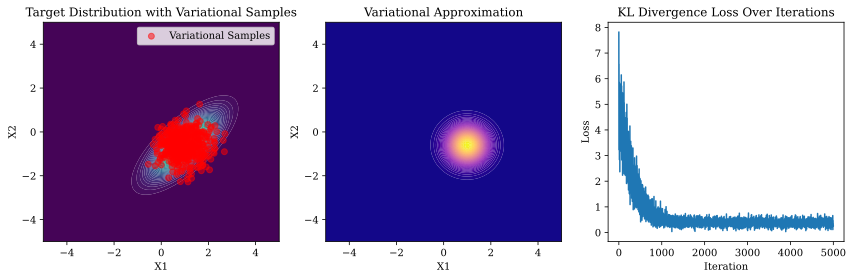

In [2]:
# Function to sample from the variational distribution q(z|λ)
def sample_variational(rng_key, mean, log_std):
    epsilon = random.normal(rng_key, shape=mean.shape)
    return mean + jnp.exp(log_std) * epsilon  # Reparameterization trick

# Function to compute the log density of the variational distribution q(z|λ)
def log_variational_density(z, mean, log_std):
    return -0.5 * jnp.sum(((z - mean) / jnp.exp(log_std)) ** 2 + 2 * log_std + jnp.log(2 * jnp.pi))

# Define the target log probability density function p(z)
def target_log_density(z):
    mu = jnp.array([1.0, -0.6])
    cov = jnp.array([[0.68, 0.5],
                     [0.5, 0.68]])
    diff = z - mu
    inv_cov = jnp.linalg.inv(cov)
    exponent = -0.5 * jnp.dot(diff.T, jnp.dot(inv_cov, diff))
    norm_const = -0.5 * (jnp.log(jnp.linalg.det(cov)) + z.size * jnp.log(2 * jnp.pi))
    return norm_const + exponent

# Function to compute the KL divergence estimate using Monte Carlo samples
def estimate_kl_divergence(mean, log_std, rng_key, num_samples=50):
    rng_keys = random.split(rng_key, num_samples)
    # Vectorized sampling and evaluation
    zs = vmap(sample_variational, in_axes=(0, None, None))(rng_keys, mean, log_std)
    log_qs = vmap(log_variational_density, in_axes=(0, None, None))(zs, mean, log_std)
    log_ps = vmap(target_log_density)(zs)
    kl_estimates = log_qs - log_ps
    return jnp.mean(kl_estimates)

# Loss function for optimization (KL divergence)
def loss_function(params, rng_key):
    mean, log_std = params
    return estimate_kl_divergence(mean, log_std, rng_key)

# Set up the optimizer
learning_rate = 1e-3
optimizer = optax.adam(learning_rate)

@jit
def optimization_step(params, rng_key, opt_state):
    loss, gradients = jax.value_and_grad(loss_function)(params, rng_key)
    updates, opt_state = optimizer.update(gradients, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss

# Initialization
dimension = 2
initial_mean = jnp.zeros(dimension)
initial_log_std = jnp.zeros(dimension)
params = (initial_mean, initial_log_std)
opt_state = optimizer.init(params)

# Training loop
num_iterations = 5000
loss_history = []

for iteration in range(num_iterations):
    rng_key = random.PRNGKey(iteration)
    params, opt_state, current_loss = optimization_step(params, rng_key, opt_state)
    loss_history.append(current_loss)

    # Print progress every 500 iterations
    if iteration % 500 == 0:
        print(f"Iteration {iteration}: Loss = {current_loss}")

# Extract optimized parameters
optimized_mean, optimized_log_std = params

# Visualization setup
grid_points = 100
x_vals = jnp.linspace(-5, 5, grid_points)
y_vals = jnp.linspace(-5, 5, grid_points)
X, Y = jnp.meshgrid(x_vals, y_vals)
grid = jnp.stack([X.ravel(), Y.ravel()], axis=-1)

# Compute target and variational densities over the grid
v_target_log_density = vmap(target_log_density)
v_log_variational_density = vmap(log_variational_density, in_axes=(0, None, None))

target_density = jnp.exp(v_target_log_density(grid)).reshape((grid_points, grid_points))
variational_density = jnp.exp(v_log_variational_density(grid, optimized_mean, optimized_log_std)).reshape((grid_points, grid_points))

# Samples from the variational distribution
sample_rng_keys = random.split(random.PRNGKey(0), 500)
samples = vmap(sample_variational, in_axes=(0, None, None))(sample_rng_keys, optimized_mean, optimized_log_std)

# Plotting all three plots in one figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Subplot 1: Target distribution with variational samples
axes[0].contourf(X, Y, target_density, levels=50, cmap='viridis')
axes[0].scatter(samples[:, 0], samples[:, 1], color='red', alpha=0.5, label='Variational Samples')
axes[0].set_title('Target Distribution with Variational Samples')
axes[0].set_xlabel('X1')
axes[0].set_ylabel('X2')
axes[0].legend()

# Subplot 2: Variational approximation
axes[1].contourf(X, Y, variational_density, levels=50, cmap='plasma')
axes[1].set_title('Variational Approximation')
axes[1].set_xlabel('X1')
axes[1].set_ylabel('X2')

# Subplot 3: Loss over iterations
axes[2].plot(loss_history)
axes[2].set_title('KL Divergence Loss Over Iterations')
axes[2].set_xlabel('Iteration')
axes[2].set_ylabel('Loss')

plt.tight_layout()
plt.show()

## Monte Carlo Methods

While **Variational Inference (VI)** offers computational efficiency, it can introduce bias into the posterior approximation because it confines the solution to a specific family of distributions $ q \in \mathcal{Q} $. A more flexible alternative is to employ a non-parametric approximation using a set of samples. Specifically, we approximate the posterior distribution $ p(\boldsymbol{\theta} \mid \mathcal{D}) $ with:

$$
q(\boldsymbol{\theta}) \approx \frac{1}{S} \sum_{s=1}^S \delta\left( \boldsymbol{\theta} - \boldsymbol{\theta}^s \right)
$$

where $\delta$ denotes the Dirac delta function, and $\{ \boldsymbol{\theta}^s \}_{s=1}^S$ are samples drawn from the posterior. This approach is known as a **Monte Carlo approximation**. The main challenge is efficiently generating samples $ \boldsymbol{\theta}^s \sim p(\boldsymbol{\theta} \mid \mathcal{D}) $ without computing the normalization constant $ p(\mathcal{D}) = \int p(\boldsymbol{\theta}, \mathcal{D}) \, d\boldsymbol{\theta} $.

For low-dimensional problems, techniques like **rejection sampling** or **importance sampling** can be effective. However, in high-dimensional spaces, these methods become inefficient, and **Markov Chain Monte Carlo (MCMC)** methods are often preferred.

### Monte Carlo Integration

**Monte Carlo methods** provide a stochastic framework for approximating integrals using random sampling. They're particularly valuable when dealing with high-dimensional integrals that are otherwise intractable through deterministic numerical methods.

Suppose we aim to compute the expected value of a function $ f(\boldsymbol{x})$ with respect to a probability distribution $w(\boldsymbol{x})$:

$$
\mathbb{E}_{w}[ f(\boldsymbol{x}) ] = \int f(\boldsymbol{x}) \, w(\boldsymbol{x}) \, d\boldsymbol{x}
$$

Here, $ \boldsymbol{x} \in \mathbb{R}^n $, $ f: \mathbb{R}^n \rightarrow \mathbb{R}^m $, and $ w(\boldsymbol{x}) $ is the target probability density function. In low dimensions (up to about three), we might use numerical integration methods that evaluate $ f $ across a grid of points. However, as the dimensionality $ n $ increases, the number of grid points needed grows exponentially—a phenomenon known as the **curse of dimensionality**—rendering grid-based methods impractical.

**Monte Carlo integration** addresses this by drawing $ N_s $ independent samples $ \{ \boldsymbol{x}_n \}_{n=1}^{N_s} $ from $ w(\boldsymbol{x}) $ and estimating the expected value as:

$$
\mathbb{E}_{w}[ f(\boldsymbol{x}) ] \approx \frac{1}{N_s} \sum_{n=1}^{N_s} f( \boldsymbol{x}_n )
$$

This method has several advantages:

- **Dimensional Independence**: The accuracy of the estimate primarily depends on the number of samples $ N_s $, not the dimensionality $ n $. This makes Monte Carlo methods suitable for high-dimensional problems.
- **Adaptive Sampling**: Samples are drawn where $ w(\boldsymbol{x}) $ is significant, ensuring that computational effort is focused on relevant regions of the integration domain.

However, there are challenges to consider:

- **Sample Generation**: Efficiently generating samples $ \boldsymbol{x}_n \sim w(\boldsymbol{x}) $ can be difficult, especially when $ w(\boldsymbol{x}) $ is complex or unnormalized.
- **Estimator Variance**: The variance of the Monte Carlo estimator can be high, requiring a large number of samples to achieve the desired accuracy.
- **Convergence Rate**: The convergence rate of Monte Carlo integration is relatively slow, at $ \mathcal{O}(1 / \sqrt{N_s}) $, where $ N_s $ is the number of samples.

### Generating Random Samples from Simple Distributions

Previously, we explored how to compute expectations $ \mathbb{E}[f(X)] $ for various functions $ f $ of a random variable $ X $ using Monte Carlo integration. A fundamental challenge in this approach is efficiently generating random samples from the target probability distribution $ w(\boldsymbol{x}) $.

**Sampling Using the Inverse Transform Method**

One of the simplest methods for sampling from a univariate probability distribution involves the **inverse transform method**, which utilizes the cumulative distribution function (CDF) of the desired distribution.

Let $ F(x) $ be the CDF of the distribution we want to sample from, and let $ F^{-1} $ denote its inverse function. The inverse transform method states that if we have a random variable $ U $ uniformly distributed over the interval $ [0, 1] $, denoted $ U \sim \text{Uniform}(0, 1) $, then:

$$
X = F^{-1}(U)
$$

The random variable $ X $ generated in this way follows the target distribution with CDF $ F $, that is:

$$
X \sim F
$$

By applying the inverse CDF to samples drawn from a uniform distribution, we effectively transform the uniformly distributed random variables into samples from the desired distribution. This method is particularly useful when the inverse CDF $ F^{-1} $ can be computed analytically or efficiently approximated.

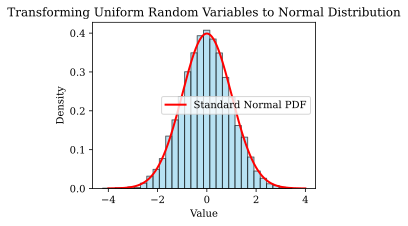

In [3]:
# Set a random seed for reproducibility
np.random.seed(42)

# Generate uniform random variables between 0 and 1
uniform_samples = np.random.uniform(low=0.0, high=1.0, size=10000)

# Transform the uniform samples using the inverse CDF (quantile function) of the standard normal distribution
normal_samples = norm.ppf(uniform_samples)

# Plot the histogram of the transformed samples
plt.figure(figsize=(4, 3), dpi=100)
plt.hist(normal_samples, bins=30, density=True, alpha=0.6, color='skyblue', edgecolor='black')

# Overlay the standard normal probability density function (PDF) for comparison
x_values = np.linspace(-4, 4, 1000)
pdf_values = norm.pdf(x_values)
plt.plot(x_values, pdf_values, 'r', linewidth=2, label='Standard Normal PDF')

# Add titles and labels
plt.title("Transforming Uniform Random Variables to Normal Distribution")
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()

# Show the plot
plt.show()

### Sampling from a Gaussian Distribution (Box-Muller Method)

To generate samples from a Gaussian distribution, we can use the **Box-Muller method**, which transforms uniformly distributed random variables into normally distributed ones. The core idea is to sample points uniformly within the unit circle and then apply a transformation that produces independent standard normal variables.

**Steps:**

1. **Sample Uniform Points within the Unit Circle**:

   - Generate random numbers $ z_1 $ and $ z_2 $ uniformly distributed over the interval $ (-1, 1) $.
   - Compute $ r^2 = z_1^2 + z_2^2 $.
   - If $ r^2 \geq 1 $ or $ r^2 = 0 $, discard the pair and resample. This ensures the points $ (z_1, z_2) $ lie inside the unit circle.

2. **Transform to Gaussian Variables**:

   - Compute:
     $$
     x_i = z_i \sqrt{ \frac{ -2 \ln r^2 }{ r^2 } }
     $$
     for $ i = 1, 2 $.

This transformation maps the uniformly distributed points within the unit circle to points that are distributed according to a standard normal distribution.

**Explanation**:

- The probability density function of uniformly distributed points inside the unit circle is:
  $$
  p(z_1, z_2) = \frac{1}{\pi}, \quad \text{for } z_1^2 + z_2^2 \leq 1
  $$
- Using the transformation and the change of variables formula, the joint probability density function of $ x_1 $ and $ x_2 $ becomes:
  $$
  p(x_1, x_2) = p(z_1, z_2) \left| \frac{\partial(z_1, z_2)}{\partial(x_1, x_2)} \right| = \left( \frac{1}{\sqrt{2\pi}} e^{ -\frac{1}{2} x_1^2 } \right) \left( \frac{1}{\sqrt{2\pi}} e^{ -\frac{1}{2} x_2^2 } \right)
  $$
- This confirms that $ x_1 $ and $ x_2 $ are independent standard normal random variables.

Thus, $ x_1 $ and $ x_2 $ are two independent samples from a univariate Gaussian distribution, obtained via the Box-Muller method.

### Sampling from a Multivariate Gaussian Distribution

To sample from a multivariate Gaussian distribution with mean vector $ \boldsymbol{\mu} $ and covariance matrix $ \boldsymbol{\Sigma} $, follow these steps:

1. **Compute the Cholesky Decomposition**:

   - Compute the Cholesky decomposition of the covariance matrix:
     $$
     \boldsymbol{\Sigma} = \boldsymbol{L} \boldsymbol{L}^\top
     $$
     where $ \boldsymbol{L} $ is a lower triangular matrix.

2. **Generate Standard Normal Samples**:

   - Use the Box-Muller method to generate a vector $ \boldsymbol{x} $ of independent standard normal variables:
     $$
     \boldsymbol{x} \sim \mathcal{N}(\mathbf{0}, \boldsymbol{I})
     $$

3. **Transform to the Desired Distribution**:

   - Compute:
     $$
     \boldsymbol{y} = \boldsymbol{L} \boldsymbol{x} + \boldsymbol{\mu}
     $$
   - The resulting vector $ \boldsymbol{y} $ follows the multivariate Gaussian distribution:
     $$
     \boldsymbol{y} \sim \mathcal{N}(\boldsymbol{\mu}, \boldsymbol{\Sigma})
     $$

**Justification**:

- The covariance of $ \boldsymbol{y} $ is:
  $$
  \operatorname{Cov}[ \boldsymbol{y} ] = \boldsymbol{L} \operatorname{Cov}[ \boldsymbol{x} ] \boldsymbol{L}^\top = \boldsymbol{L} \boldsymbol{I} \boldsymbol{L}^\top = \boldsymbol{\Sigma}
  $$
- The mean of $ \boldsymbol{y} $ is:
  $$
  \mathbb{E}[ \boldsymbol{y} ] = \boldsymbol{L} \mathbb{E}[ \boldsymbol{x} ] + \boldsymbol{\mu} = \boldsymbol{\mu}
  $$

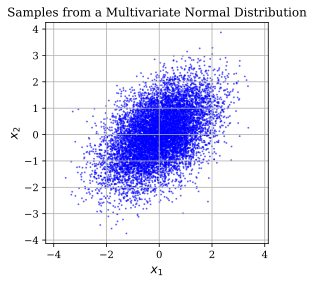

In [4]:
# Define the mean vector and covariance matrix of the multivariate normal distribution
mean_vector = np.array([0.0, 0.0])  # Mean of each dimension
covariance_matrix = np.array([[1.0, 0.5],
                            [0.5, 1.0]])  # Covariance between dimensions

# Generate samples from the multivariate normal distribution
num_samples = 10000
rng = np.random.default_rng(seed=42)  # Use a random number generator with a seed for reproducibility
samples = rng.multivariate_normal(mean=mean_vector, cov=covariance_matrix, size=num_samples)

# Plot the samples as a scatter plot
plt.figure(figsize=(4, 4), dpi=100)
plt.scatter(samples[:, 0], samples[:, 1], s=1, c='blue', alpha=0.5)
plt.xlabel('$x_1$', fontsize=12)
plt.ylabel('$x_2$', fontsize=12)
plt.title('Samples from a Multivariate Normal Distribution')
plt.axis('equal')  # Ensure equal scaling on both axes
plt.grid(True)
plt.show()

### Rejection Sampling

When we want to generate samples from a target probability distribution $ p(\boldsymbol{x}) $ that may be difficult to sample from directly, we can use **rejection sampling**. Let's consider the target distribution defined as:

$$
p(\boldsymbol{x}) = \frac{ \tilde{p}(\boldsymbol{x}) }{ Z_p }
$$

Here, $ \tilde{p}(\boldsymbol{x}) $ represents the unnormalized probability density function, and $ Z_p $ is the normalization constant (also known as the partition function), given by:

$$
Z_p = \int \tilde{p}(\boldsymbol{x}) \, d\boldsymbol{x}
$$

Often, $ Z_p $ is unknown or difficult to compute analytically.

**Rejection sampling** allows us to draw samples from $ p(\boldsymbol{x}) $ by utilizing an alternative distribution $ q(\boldsymbol{x}) $, known as the **proposal distribution**, from which we can easily generate samples. The key requirement is that there exists a constant $ k \geq 1 $ such that:

$$
k \, q(\boldsymbol{x}) \geq \tilde{p}(\boldsymbol{x}) \quad \text{for all } \boldsymbol{x}
$$

This inequality ensures that $ k \, q(\boldsymbol{x}) $ acts as an **upper bound** or **envelope** over the unnormalized target density $ \tilde{p}(\boldsymbol{x}) $.

The **rejection sampling algorithm** proceeds as follows:

1. **Sample a Candidate Point**:
   - Draw $ \boldsymbol{x}_0 $ from the proposal distribution:
     $$
     \boldsymbol{x}_0 \sim q(\boldsymbol{x})
     $$
     This step selects a random point $ \boldsymbol{x}_0 $ in the space according to $ q(\boldsymbol{x}) $.

2. **Generate a Uniform Random Variable**:
   - Draw $ u $ from the uniform distribution over the interval $ [0, 1] $:
     $$
     u \sim \text{Uniform}(0, 1)
     $$
   
3. **Accept or Reject the Candidate**:
   - Compute the acceptance ratio:
     $$
     \alpha = \frac{ \tilde{p}(\boldsymbol{x}_0) }{ k \, q(\boldsymbol{x}_0) }
     $$
   - If $ u \leq \alpha $, accept $ \boldsymbol{x}_0 $ as a sample from $ p(\boldsymbol{x}) $.
   - Otherwise, reject $ \boldsymbol{x}_0 $ and return to step 1.

**Geometric Interpretation**:

- Imagine plotting $ k \, q(\boldsymbol{x}) $ and $ \tilde{p}(\boldsymbol{x}) $ over the domain of $ \boldsymbol{x} $. The curve $ k \, q(\boldsymbol{x}) $ envelopes $ \tilde{p}(\boldsymbol{x}) $.
- For each candidate $ \boldsymbol{x}_0 $, we generate a vertical coordinate $ u_0 = u \times k \, q(\boldsymbol{x}_0) $, effectively picking a random point under the envelope curve.
- If this point lies below $ \tilde{p}(\boldsymbol{x}_0) $, we accept $ \boldsymbol{x}_0 $; otherwise, we reject it.

**Acceptance Probability**:

The probability of accepting a candidate point $ \boldsymbol{x}_0 $ is:

$$
P_{\text{accept}}(\boldsymbol{x}_0) = \frac{ \tilde{p}(\boldsymbol{x}_0) }{ k \, q(\boldsymbol{x}_0) }
$$

This means that candidates where $ \tilde{p}(\boldsymbol{x}_0) $ is large relative to $ q(\boldsymbol{x}_0) $ are more likely to be accepted.

**Efficiency Considerations**:

- **Choice of Proposal Distribution**: The efficiency of rejection sampling heavily depends on the choice of $ q(\boldsymbol{x}) $ and the constant $ k $. Ideally, $ q(\boldsymbol{x}) $ should closely approximate $ \tilde{p}(\boldsymbol{x}) / Z_p $, and $ k $ should be as small as possible (but still satisfy the envelope condition).
- **Curse of Dimensionality**: In high-dimensional spaces, the acceptance probability can become exceedingly low. This is because the volume where $ \tilde{p}(\boldsymbol{x}) $ is significant occupies a vanishingly small fraction of the total space covered by $ q(\boldsymbol{x}) $. As a result, the number of rejected samples may grow exponentially with the dimensionality, making rejection sampling inefficient for high-dimensional problems.

 97%|█████████▋| 38913/40000 [00:04<00:00, 7999.97it/s]


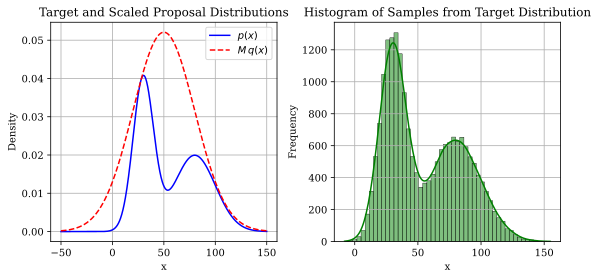

In [5]:
# Define the target probability density function (PDF) as a mixture of two Gaussians
def target_density(x):
  component1 = norm.pdf(x, loc=30, scale=10)
  component2 = norm.pdf(x, loc=80, scale=20)
  return component1 + component2

# Define the proposal PDF as a single Gaussian
def proposal_density(x):
  return norm.pdf(x, loc=50, scale=30)

# Rejection sampling algorithm
def perform_rejection_sampling(num_samples=1000):
  accepted_samples = []
  total_iterations = num_samples * 2  # Estimate iterations needed; adjust as necessary
  
  # Compute the constant 'M' for scaling the proposal distribution
  x_vals = np.linspace(-50, 150, 1000)
  p_vals = target_density(x_vals)
  q_vals = proposal_density(x_vals)
  M = np.max(p_vals / q_vals)
  
  # Rejection sampling loop
  for _ in trange(total_iterations):
      # Sample from the proposal distribution
      z = np.random.normal(loc=50, scale=30)
      
      # Compute the acceptance probability
      u = np.random.uniform(0, M * proposal_density(z))
      
      # Accept or reject the sample
      if u < target_density(z):
          accepted_samples.append(z)
          if len(accepted_samples) == num_samples:
              break  # Stop when we have the desired number of samples
  
  return np.array(accepted_samples)

# Generate samples using rejection sampling
num_samples = 20000
samples = perform_rejection_sampling(num_samples=num_samples)

# Visualization
# Set up the figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# First subplot: Target distribution and scaled proposal distribution
x_plot = np.linspace(-50, 150, 1000)
axes[0].plot(x_plot, target_density(x_plot), label='$p(x)$', color='blue')
axes[0].plot(x_plot, np.max(target_density(x_plot) / proposal_density(x_plot)) * proposal_density(x_plot),
           label='$M \\, q(x)$', color='red', linestyle='--')
axes[0].set_title('Target and Scaled Proposal Distributions')
axes[0].set_xlabel('x')
axes[0].set_ylabel('Density')
axes[0].legend()
axes[0].grid(True)

# Second subplot: Histogram of accepted samples
sns.histplot(samples, bins=50, kde=True, ax=axes[1], color='green')
axes[1].set_title('Histogram of Samples from Target Distribution')
axes[1].set_xlabel('x')
axes[1].set_ylabel('Frequency')
axes[1].grid(True)

plt.tight_layout()
plt.show()

### Importance Sampling

**Importance Sampling** is a Monte Carlo technique used to approximate expectations of the form:

$$
\mathbb{E}_{w}[ f(\boldsymbol{x}) ] = \int f(\boldsymbol{x}) \, w(\boldsymbol{x}) \, d\boldsymbol{x}
$$

where $ f(\boldsymbol{x}) $ is the function of interest, and $ w(\boldsymbol{x}) $ is the target probability distribution. Often, $ w(\boldsymbol{x}) $ is difficult to sample from directly, especially if it's a complex or high-dimensional distribution like a posterior $ p(\boldsymbol{x} \mid \boldsymbol{y}) $.

To overcome this challenge, we introduce a **proposal distribution** $ q(\boldsymbol{x}) $ from which we can easily draw samples. The key idea is to re-weight these samples to account for the discrepancy between $ q(\boldsymbol{x}) $ and the target distribution $ w(\boldsymbol{x}) $. This leads to a weighted Monte Carlo estimator:

$$
\mathbb{E}_{w}[ f(\boldsymbol{x}) ] \approx \sum_{n=1}^N w_n \, f(\boldsymbol{x}_n)
$$

where $ \boldsymbol{x}_n \sim q(\boldsymbol{x}) $ are samples from the proposal distribution, and $ w_n $ are the associated weights.

Assuming we can evaluate the target distribution $ w(\boldsymbol{x}) $ (even if up to a normalization constant), we can rewrite the expectation as:

$$
\mathbb{E}_{w}[ f(\boldsymbol{x}) ] = \int f(\boldsymbol{x}) \, \frac{w(\boldsymbol{x})}{q(\boldsymbol{x})} \, q(\boldsymbol{x}) \, d\boldsymbol{x}
$$

This expression allows us to compute the expectation with respect to $ w(\boldsymbol{x}) $ using samples from $ q(\boldsymbol{x}) $, adjusted by the importance weights $ \frac{w(\boldsymbol{x})}{q(\boldsymbol{x})} $.

**Requirements:**

- **Support Condition**: The proposal distribution $ q(\boldsymbol{x}) $ must be positive wherever the target distribution $ w(\boldsymbol{x}) $ is positive. This means the support of $ q(\boldsymbol{x}) $ must include the support of $ w(\boldsymbol{x}) $.

By drawing $ N $ samples $ \{ \boldsymbol{x}_n \}_{n=1}^N $ from $ q(\boldsymbol{x}) $, we approximate the expectation as:

$$
\mathbb{E}_{w}[ f(\boldsymbol{x}) ] \approx \frac{1}{N} \sum_{n=1}^{N} \frac{w(\boldsymbol{x}_n)}{q(\boldsymbol{x}_n)} \, f(\boldsymbol{x}_n) = \frac{1}{N} \sum_{n=1}^{N} \tilde{w}_n \, f(\boldsymbol{x}_n)
$$

Here, we define the **unnormalized importance weights** $ \tilde{w}_n $ as:

$$
\tilde{w}_n = \frac{w(\boldsymbol{x}_n)}{q(\boldsymbol{x}_n)}
$$

This estimator is **unbiased**, meaning that its expected value equals the true expectation $ \mathbb{E}_{w}[ f(\boldsymbol{x}) ] $.

**Challenges and Limitations:**

- **Variance Issues**: In practice, importance sampling can suffer from high variance, especially in high-dimensional settings. The importance weights $ \tilde{w}_n $ may vary greatly in magnitude, with some weights being extremely large and others negligible. This imbalance can make the estimator unstable and inefficient.
  
- **Curse of Dimensionality**: As the dimensionality of $ \boldsymbol{x} $ increases, the probability that samples from $ q(\boldsymbol{x}) $ land in regions where $ w(\boldsymbol{x}) $ is significant decreases exponentially. Consequently, many samples contribute little to the estimate, necessitating a very large number of samples to achieve reasonable accuracy.

**Practical Considerations:**

- **Choice of Proposal Distribution**: Selecting an appropriate $ q(\boldsymbol{x}) $ is crucial. Ideally, the proposal distribution should closely resemble the target distribution $ w(\boldsymbol{x}) $ to ensure that the importance weights are balanced.

- **Weight Normalization**: Sometimes, it's beneficial to normalize the weights to sum to one:

  $$
  w_n = \frac{ \tilde{w}_n }{ \sum_{k=1}^N \tilde{w}_k }
  $$

  This adjusted estimator still approximates the expectation but with potentially reduced variance.

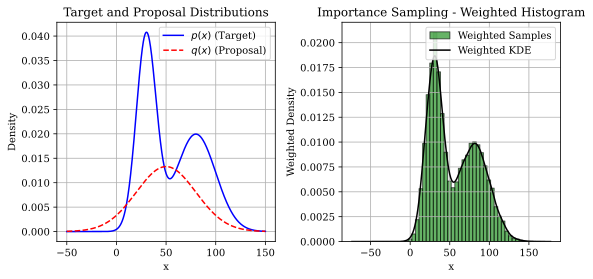

In [6]:
# Define the target probability density function (PDF) as a mixture of two Gaussians
def target_pdf(x):
  # First Gaussian component
  pdf1 = norm.pdf(x, loc=30, scale=10)
  # Second Gaussian component
  pdf2 = norm.pdf(x, loc=80, scale=20)
  # Mixture PDF (sum of components)
  return pdf1 + pdf2

# Define the proposal PDF as a single Gaussian distribution
def proposal_pdf(x):
  return norm.pdf(x, loc=50, scale=30)

# Importance sampling function
def importance_sampling(num_samples=10000):
  # Sample from the proposal distribution
  proposal_samples = np.random.normal(loc=50, scale=30, size=num_samples)
  
  # Compute the importance weights for each sample
  weights = target_pdf(proposal_samples) / proposal_pdf(proposal_samples)
  
  # Normalize the weights
  normalized_weights = weights / np.sum(weights)
  
  return proposal_samples, normalized_weights

# Set the number of samples for importance sampling
num_samples = 20000

# Perform importance sampling
samples, weights = importance_sampling(num_samples=num_samples)

# Visualization
# Set up the figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# First subplot: Target and proposal distributions
x_range = np.linspace(-50, 150, 1000)
axes[0].plot(x_range, target_pdf(x_range), label='$p(x)$ (Target)', color='blue')
axes[0].plot(x_range, proposal_pdf(x_range), label='$q(x)$ (Proposal)', color='red', linestyle='--')
axes[0].set_title('Target and Proposal Distributions')
axes[0].set_xlabel('x')
axes[0].set_ylabel('Density')
axes[0].legend()
axes[0].grid(True)

# Second subplot: Histogram of samples weighted by importance weights
axes[1].hist(samples, bins=50, weights=weights, density=True, color='green', alpha=0.6, edgecolor='black', label='Weighted Samples')
sns.kdeplot(x=samples, weights=weights, color='black', label='Weighted KDE', ax=axes[1])
axes[1].set_title('Importance Sampling - Weighted Histogram')
axes[1].set_xlabel('x')
axes[1].set_ylabel('Weighted Density')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

## Markov Chain Monte Carlo (MCMC)

Previously, we discussed non-iterative Monte Carlo methods like rejection sampling and importance sampling, which generate independent samples from a target distribution. However, these methods often become inefficient in high-dimensional spaces due to the **curse of dimensionality**.

To overcome this challenge, we turn to **Markov Chain Monte Carlo (MCMC)** methods, which are specifically designed for sampling from high-dimensional probability distributions. The fundamental idea behind MCMC is to construct a Markov chain whose **stationary distribution** matches the target distribution $ p^*(\boldsymbol{x}) $ we wish to sample from.

In MCMC, we perform a random walk through the state space $ \mathcal{X} $ in such a way that the proportion of time the chain spends in each state $ \boldsymbol{x} $ is proportional to $ p^*(\boldsymbol{x}) $. This is achieved by designing transition probabilities that satisfy certain conditions (e.g., detailed balance).

By generating a sequence of (correlated) samples $ \boldsymbol{x}_0, \boldsymbol{x}_1, \boldsymbol{x}_2, \ldots $ from this Markov chain, we can perform Monte Carlo integration with respect to $ p^*(\boldsymbol{x}) $. Although these samples are not independent, they can still provide accurate estimates of expectations under $ p^*(\boldsymbol{x}) $.

It's important to note that the initial samples produced by the Markov chain may not accurately represent the target distribution, as the chain may not have reached its stationary distribution yet. The number of steps required for the chain to converge to the stationary distribution is known as the **burn-in period** or **mixing time**. Samples drawn during this period are typically discarded to reduce bias in our estimates. Reducing the burn-in time is crucial for improving the efficiency of MCMC algorithms, and we'll explore techniques to achieve this in later sections.

For an intuitive understanding of how MCMC works, you can explore this interactive [Visualization of MCMC](https://chi-feng.github.io/mcmc-demo/app.html).

## Metropolis-Hastings (MH) Algorithm

The **Metropolis-Hastings (MH)** algorithm is a fundamental method in Markov Chain Monte Carlo (MCMC) techniques, widely used for sampling from complex probability distributions, especially in high-dimensional spaces.

### Basic Concept

At each iteration of the Metropolis-Hastings algorithm, we start from the current state $ \boldsymbol{x} $ and propose a new state $ \boldsymbol{x}' $ based on a **proposal distribution** $ q(\boldsymbol{x}' \mid \boldsymbol{x}) $, also known as the **transition kernel**. The proposal distribution can be chosen flexibly, allowing for a wide range of strategies to explore the state space.

After proposing $ \boldsymbol{x}' $, we decide whether to accept or reject this new state to ensure that the Markov chain formed by the sequence $ \boldsymbol{x}^0, \boldsymbol{x}^1, \boldsymbol{x}^2, \ldots $ has the desired **stationary distribution** $ p^*(\boldsymbol{x}) $, which is the target distribution we wish to sample from.

- **If the proposal is accepted**: We move to the new state $ \boldsymbol{x}' $.
- **If the proposal is rejected**: We remain at the current state $ \boldsymbol{x} $.

This accept/reject mechanism allows the algorithm to explore the state space while correctly sampling from $ p^*(\boldsymbol{x}) $.

### Acceptance Probability

#### Symmetric Proposal Distribution

When the proposal distribution is **symmetric**, meaning it satisfies:

$$
q(\boldsymbol{x}' \mid \boldsymbol{x}) = q(\boldsymbol{x} \mid \boldsymbol{x}'),
$$

the acceptance probability $ A $ simplifies to:

$$
A = \min\left(1, \frac{p^*(\boldsymbol{x}')}{p^*(\boldsymbol{x})}\right).
$$

**Interpretation**:

- If the proposed state $ \boldsymbol{x}' $ has a higher probability under the target distribution than the current state $ \boldsymbol{x} $ (i.e., $ p^*(\boldsymbol{x}') > p^*(\boldsymbol{x}) $), the move is always accepted.
- If $ \boldsymbol{x}' $ has a lower probability, the move is accepted with probability proportional to $ \frac{p^*(\boldsymbol{x}')}{p^*(\boldsymbol{x})} $.

This mechanism allows the algorithm to occasionally move to less probable states, preventing it from getting stuck in local maxima and ensuring thorough exploration of the state space.

#### Asymmetric Proposal Distribution

When the proposal distribution is **asymmetric**, meaning:

$$
q(\boldsymbol{x}' \mid \boldsymbol{x}) \neq q(\boldsymbol{x} \mid \boldsymbol{x}'),
$$

we need to adjust the acceptance probability to account for the asymmetry. This is achieved using the **Hastings correction**, resulting in the acceptance probability:

$$
A = \min(1, \alpha),
$$

where

$$
\alpha = \frac{p^*(\boldsymbol{x}') \, q(\boldsymbol{x} \mid \boldsymbol{x}')}{p^*(\boldsymbol{x}) \, q(\boldsymbol{x}' \mid \boldsymbol{x})}.
$$

**Explanation**:

- The Hastings correction compensates for any bias introduced by the asymmetric proposal distribution.
- The acceptance ratio $ \alpha $ ensures detailed balance, which is necessary for the Markov chain to converge to the target distribution $ p^*(\boldsymbol{x}) $.

### Practical Advantage

A key advantage of the Metropolis-Hastings algorithm is that it only requires knowledge of the target density $ p^*(\boldsymbol{x}) $ up to a normalization constant. Suppose the target distribution is known in unnormalized form:

$$
p^*(\boldsymbol{x}) = \frac{1}{Z} \, \tilde{p}(\boldsymbol{x}),
$$

where:

- $ \tilde{p}(\boldsymbol{x}) $ is the unnormalized target density.
- $ Z $ is the normalization constant (partition function), which may be difficult or impossible to compute.

In the acceptance ratio $ \alpha $, the normalization constants cancel out:

$$
\alpha = \frac{\tilde{p}(\boldsymbol{x}') \, q(\boldsymbol{x} \mid \boldsymbol{x}')}{\tilde{p}(\boldsymbol{x}) \, q(\boldsymbol{x}' \mid \boldsymbol{x})}.
$$

This property allows us to implement the algorithm without needing to compute $ Z $, making the Metropolis-Hastings method practical for complex distributions.

### Metropolis-Hastings Algorithm Steps

Here is the step-by-step procedure for the Metropolis-Hastings algorithm:

1. **Initialization**:
   - Choose an initial state $ \boldsymbol{x}^0 $.
2. **Iteration** ($ s = 0, 1, 2, \ldots $):
   - **Current State**:
     - Set $ \boldsymbol{x} = \boldsymbol{x}^s $.
   - **Proposal Step**:
     - Sample a proposed state $ \boldsymbol{x}' $ from the proposal distribution:
       $$
       \boldsymbol{x}' \sim q(\boldsymbol{x}' \mid \boldsymbol{x}).
       $$
   - **Compute Acceptance Ratio**:
     - Calculate the unnormalized acceptance ratio:
       $$
       \alpha = \frac{\tilde{p}(\boldsymbol{x}') \, q(\boldsymbol{x} \mid \boldsymbol{x}')}{\tilde{p}(\boldsymbol{x}) \, q(\boldsymbol{x}' \mid \boldsymbol{x})}.
       $$
   - **Determine Acceptance Probability**:
     - Compute the acceptance probability:
       $$
       A = \min(1, \alpha).
       $$
   - **Acceptance or Rejection**:
     - Draw a uniform random number $ u \sim \text{Uniform}(0, 1) $.
     - **If** $ u \leq A $ (accept the proposal):
       - Set $ \boldsymbol{x}^{s+1} = \boldsymbol{x}' $.
     - **Else** (reject the proposal):
       - Set $ \boldsymbol{x}^{s+1} = \boldsymbol{x} $.
3. **Repeat**:
   - Continue iterating to generate a sequence of samples $ \{ \boldsymbol{x}^s \} $.

By following these steps, the Metropolis-Hastings algorithm generates a Markov chain whose states are samples from the target distribution $ p^*(\boldsymbol{x}) $ after an initial burn-in period.

## Gibbs Sampling

One of the main challenges with the Metropolis-Hastings (MH) algorithm is selecting an appropriate proposal distribution and dealing with potentially low acceptance rates. **Gibbs Sampling** offers a solution by leveraging the conditional independence properties of **graphical models** to automatically generate proposals that are always accepted.

The core idea behind Gibbs sampling is to sequentially sample each variable from its conditional distribution, given the current values of all other variables. For instance, if we have $ D = 3 $ variables, the sampling steps at iteration $ s+1 $ would be:

- $ x_1^{(s+1)} \sim p\left( x_1 \mid x_2^{(s)}, \, x_3^{(s)} \right) $
- $ x_2^{(s+1)} \sim p\left( x_2 \mid x_1^{(s+1)}, \, x_3^{(s)} \right) $
- $ x_3^{(s+1)} \sim p\left( x_3 \mid x_1^{(s+1)}, \, x_2^{(s+1)} \right) $

This process naturally extends to any number of variables $ D $. (If a variable $ x_i $ is observed or fixed, we do not sample it, but we can still condition on it when sampling other variables.)

The distribution $ p\left( x_i \mid \boldsymbol{x}_{-i} \right) $ is known as the **full conditional distribution** of variable $ x_i $, where $ \boldsymbol{x}_{-i} $ denotes all variables except $ x_i $. In practice, $ x_i $ may depend only on a subset of the other variables due to conditional independencies in the model. By representing $ p(\boldsymbol{x}) $ as a graphical model, we can identify the dependencies of $ x_i $ by examining its **Markov blanket**, which consists of the neighboring nodes directly connected to $ x_i $. Therefore, we can write:

$$
x_i^{(s+1)} \sim p\left( x_i \mid \boldsymbol{x}_{-i}^{(s)} \right) = p\left( x_i \mid \boldsymbol{x}_{\text{MB}(i)}^{(s)} \right)
$$

Here, $ \boldsymbol{x}_{\text{MB}(i)}^{(s)} $ represents the current values of the variables in the Markov blanket of $ x_i $ at iteration $ s $.

## Hamiltonian Monte Carlo (HMC)

Many Markov Chain Monte Carlo (MCMC) algorithms struggle in high-dimensional spaces because they rely on random local perturbations, which can lead to slow exploration of the target distribution. **Hamiltonian Monte Carlo (HMC)** addresses this issue by incorporating gradient information to guide the sampling process more efficiently.

### Hamiltonian Mechanics

In physics, the motion of a particle in a conservative energy field can be described using Hamiltonian mechanics. The state of the particle is characterized by its position $ \boldsymbol{\theta} \in \mathbb{R}^D $ (often denoted as $ \boldsymbol{q} $) and momentum $ \boldsymbol{p} \in \mathbb{R}^D $. The combined set $ (\boldsymbol{\theta}, \boldsymbol{p}) $ forms the **phase space**.

The **Hamiltonian function** $ \mathcal{H}(\boldsymbol{\theta}, \boldsymbol{p}) $ represents the total energy (kinetic plus potential) of the system:

$$
\mathcal{H}(\boldsymbol{\theta}, \boldsymbol{p}) = \mathcal{E}(\boldsymbol{\theta}) + \mathcal{K}(\boldsymbol{p})
$$

- $ \mathcal{E}(\boldsymbol{\theta}) $ is the **potential energy**.
- $ \mathcal{K}(\boldsymbol{p}) $ is the **kinetic energy**.

In a statistical context, we relate the potential energy to the negative logarithm of the target probability density function:

$$
\mathcal{E}(\boldsymbol{\theta}) = - \log \tilde{p}(\boldsymbol{\theta})
$$

where $ \tilde{p}(\boldsymbol{\theta}) $ is the unnormalized target distribution (e.g., the posterior distribution in Bayesian inference).

The kinetic energy is typically defined as:

$$
\mathcal{K}(\boldsymbol{p}) = \frac{1}{2} \boldsymbol{p}^\top \mathbf{M}^{-1} \boldsymbol{p}
$$

- $ \mathbf{M} $ is a positive-definite **mass matrix** (often set to the identity matrix $ \mathbf{I} $ for simplicity).

The dynamics of the system are governed by **Hamilton's equations**:

$$
\begin{aligned}
\frac{d\boldsymbol{\theta}}{dt} &= \phantom{-} \frac{\partial \mathcal{H}}{\partial \boldsymbol{p}} = \mathbf{M}^{-1} \boldsymbol{p} \\
\frac{d\boldsymbol{p}}{dt} &= -\frac{\partial \mathcal{H}}{\partial \boldsymbol{\theta}} = -\nabla_{\boldsymbol{\theta}} \mathcal{E}(\boldsymbol{\theta})
\end{aligned}
$$

These equations describe how the position and momentum evolve over time:

- The position $ \boldsymbol{\theta} $ changes according to the momentum.
- The momentum $ \boldsymbol{p} $ changes according to the gradient of the potential energy.

An important property of Hamiltonian dynamics is that the **total energy** $ \mathcal{H}(\boldsymbol{\theta}, \boldsymbol{p}) $ is conserved over time:

$$
\frac{d \mathcal{H}}{dt} = 0
$$

This conservation implies that the trajectory of the particle moves along contours of constant energy. Additionally, Hamiltonian dynamics are **volume-preserving** and **reversible**, properties essential for constructing valid MCMC algorithms.

### The HMC Algorithm

We can use Hamiltonian dynamics to inform the proposal mechanism in our MCMC sampler. By simulating the particle's movement through the phase space $ (\boldsymbol{\theta}, \boldsymbol{p}) $, we can generate proposals that efficiently explore the target distribution.

#### Target Distribution

The joint target distribution over positions $ \boldsymbol{\theta} $ and momenta $ \boldsymbol{p} $ is:

$$
p(\boldsymbol{\theta}, \boldsymbol{p}) = \frac{1}{Z} \exp\left( -\mathcal{H}(\boldsymbol{\theta}, \boldsymbol{p}) \right) = \frac{1}{Z} \exp\left( -\mathcal{E}(\boldsymbol{\theta}) - \mathcal{K}(\boldsymbol{p}) \right)
$$

Since $ \mathcal{K}(\boldsymbol{p}) $ is quadratic in $ \boldsymbol{p} $, the marginal distribution over $ \boldsymbol{p} $ is Gaussian:

$$
p(\boldsymbol{p}) = \mathcal{N}(\boldsymbol{p} \mid \mathbf{0}, \mathbf{M})
$$

Our goal is to sample from the marginal distribution $ p(\boldsymbol{\theta}) $, which corresponds to the original target distribution:

$$
p(\boldsymbol{\theta}) = \int p(\boldsymbol{\theta}, \boldsymbol{p}) \, d\boldsymbol{p} \propto \exp\left( -\mathcal{E}(\boldsymbol{\theta}) \right) = \tilde{p}(\boldsymbol{\theta})
$$

#### Algorithm Steps

The HMC algorithm proceeds as follows:

1. **Sample Momentum**:

   At iteration $ t $, given the current position $ \boldsymbol{\theta}_{t-1} $, sample a new momentum from its Gaussian distribution:

   $$
   \boldsymbol{p}_{t-1} \sim \mathcal{N}\left( \mathbf{0}, \mathbf{M} \right)
   $$

2. **Simulate Hamiltonian Dynamics**:

   Starting from $ (\boldsymbol{\theta}_{t-1}, \boldsymbol{p}_{t-1}) $, simulate the Hamiltonian dynamics using the **leapfrog integrator** with step size $ \epsilon $ for $ L $ steps:

   - **Initialization**:
     - $ \boldsymbol{\theta}_0 = \boldsymbol{\theta}_{t-1} $
     - $ \boldsymbol{p}_0 = \boldsymbol{p}_{t-1} $

   - **Leapfrog Steps**:

     For $ n = 0 $ to $ L-1 $:

     a. **Half-step for momentum**:

     $$
     \boldsymbol{p}_{n+\frac{1}{2}} = \boldsymbol{p}_n - \frac{\epsilon}{2} \nabla_{\boldsymbol{\theta}} \mathcal{E}\left( \boldsymbol{\theta}_n \right)
     $$

     b. **Full-step for position**:

     $$
     \boldsymbol{\theta}_{n+1} = \boldsymbol{\theta}_n + \epsilon \, \mathbf{M}^{-1} \boldsymbol{p}_{n+\frac{1}{2}}
     $$

     c. **Half-step for momentum**:

     $$
     \boldsymbol{p}_{n+1} = \boldsymbol{p}_{n+\frac{1}{2}} - \frac{\epsilon}{2} \nabla_{\boldsymbol{\theta}} \mathcal{E}\left( \boldsymbol{\theta}_{n+1} \right)
     $$

   - **Result**:

     After $ L $ steps, we obtain the proposal $ (\boldsymbol{\theta}^*, \boldsymbol{p}^*) = (\boldsymbol{\theta}_L, \boldsymbol{p}_L) $.

3. **Metropolis Acceptance Step**:

   - **Compute Change in Hamiltonian**:

     $$
     \Delta \mathcal{H} = \mathcal{H}\left( \boldsymbol{\theta}^*, \boldsymbol{p}^* \right) - \mathcal{H}\left( \boldsymbol{\theta}_{t-1}, \boldsymbol{p}_{t-1} \right)
     $$

   - **Accept or Reject**:

     - With probability $ \alpha = \min\left( 1, \exp\left( -\Delta \mathcal{H} \right) \right) $, accept the proposal:

       $$
       \boldsymbol{\theta}_t = \boldsymbol{\theta}^*
       $$

     - Otherwise, reject the proposal and retain the current state:

       $$
       \boldsymbol{\theta}_t = \boldsymbol{\theta}_{t-1}
       $$

4. **Discard Momentum**:

   - The momentum $ \boldsymbol{p}^* $ is discarded after each iteration.

#### Key Properties

- **Efficiency**: By incorporating gradient information, HMC can make larger, informed jumps in the parameter space, reducing random walk behavior and improving convergence rates.

- **Reversibility and Volume Preservation**: The leapfrog integrator maintains these properties, ensuring the Markov chain satisfies detailed balance with respect to the target distribution.

- **Parameter Choices**:

  - The step size $ \epsilon $ and number of steps $ L $ need to be tuned for optimal performance.
  - The mass matrix $ \mathbf{M} $ can be set to the identity matrix or adapted to match the covariance structure of the target distribution.

## Sequential Monte Carlo (SMC)

While Markov Chain Monte Carlo (MCMC) methods, such as Metropolis-Hastings and Hamiltonian Monte Carlo, perform stochastic local searches through the state space of the posterior distribution by making probabilistic moves from one state to neighboring states, **Sequential Monte Carlo (SMC)** offers an alternative approach for inference. SMC methods construct a sequence of intermediate distributions that progressively approximate the target posterior distribution, starting from a simpler distribution and gradually increasing in complexity.

### Concept

The fundamental idea behind SMC is to perform inference by evolving a set of samples (often called particles) through a sequence of distributions $ \{ p_0(\boldsymbol{\theta}), p_1(\boldsymbol{\theta}), \ldots, p_T(\boldsymbol{\theta}) \} $, where:

- $ p_0(\boldsymbol{\theta}) $ is an initial simple distribution from which sampling is easy.
- $ p_T(\boldsymbol{\theta}) $ is the complex target posterior distribution $ p(\boldsymbol{\theta} \mid \mathcal{D}) $.

At each stage $ t $, the samples are moved and reweighted to better approximate the intermediate distribution $ p_t(\boldsymbol{\theta}) $. This approach allows for a gradual transformation from the initial distribution to the target distribution.

### Sequential Bayesian Inference

A common application of SMC is in **sequential Bayesian inference**, where data arrives sequentially over time, and our goal is to update our belief about the parameters $ \boldsymbol{\theta} $ as new data becomes available. Specifically, we aim to compute the posterior distribution $ p(\boldsymbol{\theta}_t \mid \mathcal{D}_{1:t}) $ at each time step $ t $, where:

- $ \boldsymbol{\theta}_t $ represents the parameters or latent variables at time $ t $.
- $ \mathcal{D}_{1:t} = \{ (\boldsymbol{x}_n, y_n) : n = 1, 2, \ldots, t \} $ is the set of all observations up to time $ t $.

As new data points are observed, the posterior distribution is updated recursively:

$$
p(\boldsymbol{\theta}_t \mid \mathcal{D}_{1:t}) \propto p(y_t \mid \boldsymbol{x}_t, \boldsymbol{\theta}_t) \, p(\boldsymbol{\theta}_t \mid \mathcal{D}_{1:t-1})
$$

This sequential updating continues indefinitely if the data stream is unending, making SMC particularly suitable for online inference tasks.

### Particle Filtering

When applying SMC to **state-space models** or dynamical systems where the hidden state evolves over time, the methodology is often referred to as **particle filtering**. In this context:

- The hidden state $ \boldsymbol{\theta}_t $ evolves according to some dynamical process.
- Observations $ y_t $ provide indirect information about the hidden state.

Particle filtering approximates the posterior distribution of the hidden state using a set of weighted particles $ \{ (\boldsymbol{\theta}_t^{(i)}, w_t^{(i)}) \}_{i=1}^N $, where:

- $ \boldsymbol{\theta}_t^{(i)} $ is the state of the $ i $-th particle at time $ t $.
- $ w_t^{(i)} $ is the weight of the $ i $-th particle, reflecting its importance.

The particle filter algorithm involves:

1. **Prediction Step**: Propagate each particle $ \boldsymbol{\theta}_{t-1}^{(i)} $ according to the state transition model to obtain $ \boldsymbol{\theta}_t^{(i)} $.

2. **Update Step**: Update the weights $ w_t^{(i)} $ based on the likelihood of the new observation $ y_t $ given the particle's state.

3. **Resampling Step**: Periodically resample the particles to focus computational resources on the regions of the state space with higher probability.

### Advantages of SMC

- **Online Inference**: SMC methods are designed for scenarios where data arrives sequentially, enabling real-time updating of the posterior distribution without the need to store all past data.

- **Flexibility**: They can handle complex, non-linear, and non-Gaussian models that are intractable for analytical solutions or traditional filters like the Kalman filter.

- **Adaptability**: SMC methods can adjust the number of particles and resampling strategies based on the problem's requirements and computational resources.

### Challenges

- **Computational Complexity**: SMC methods can be computationally intensive, especially with a large number of particles or high-dimensional state spaces.

- **Particle Degeneracy**: Over time, without proper resampling strategies, the weights of some particles can dominate, leading to a lack of diversity among particles.

- **Choice of Intermediate Distributions**: Designing the sequence of intermediate distributions $ \{ p_t(\boldsymbol{\theta}) \} $ requires careful consideration to ensure efficient convergence to the target distribution.